#### Camera pose randomisation

In [1]:
import os
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "/home/andrew/Documents/Projects/2024-mujoco/madrona_mjx/build/cache"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" # Ensure that Madrona gets the chance to pre-allocate memory before Jax

In [ ]:
from mujoco_playground import wrapper
import jax
import numpy as np
import mediapy as media
import functools

In [3]:
from mujoco_playground._src.manipulation.aloha.s2r.debug import DebugDomainRandomize, domain_randomize
num_envs = 1024
env = DebugDomainRandomize()
randomizer = domain_randomize

key_rng = jax.random.PRNGKey(0)
randomizer = functools.partial(
    randomizer,
    rng=jax.random.split(key_rng, num_envs)
)

env = wrapper.wrap_for_brax_training(
    env,
    vision=True,
    num_vision_envs=num_envs,
    episode_length=100,
    action_repeat=1,
    randomization_fn=randomizer 
)

Using raytracer
Compiling /home/andrew/Documents/Projects/2025-mujoco/madrona_installs/madrona_mjx/external/madrona/src/mw/device/bvh.cpp
Compiling /home/andrew/Documents/Projects/2025-mujoco/madrona_installs/madrona_mjx/external/madrona/src/mw/device/memory.cpp
Compiling /home/andrew/Documents/Projects/2025-mujoco/madrona_installs/madrona_mjx/external/madrona/src/mw/device/host_print.cpp
Compiling /home/andrew/Documents/Projects/2025-mujoco/madrona_installs/madrona_mjx/external/madrona/src/mw/device/bvh_raycast.cpp
Compiling GPU engine code:
Initialization finished


In [4]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concatenate(np.concatenate(img, axis=1), axis=1)

def unvmap(x):
    return jax.tree.map(lambda y: y[0], x)

""

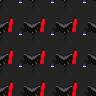

In [9]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(1), num_envs))
imgs = state.obs['pixels/view_1'][:9]
img = tile(imgs, 3)
media.show_image(img, width=700)

#### Sanity check on Mujoco Renderer
Sanity checking that changing RGBA as in distillation.py:def domain_randomize with Mujoco has correct results.

In [6]:
table_geom_id = env.mj_model.geom('table').id
peg_geom_id   = env.mj_model.geom('red_peg').id

In [7]:
# Perturb the peg's off-colors
import mujoco
scene_option = mujoco.MjvOption()
scene_option.geomgroup[0] = False # Match madrona's geom_group setting.
scene_option.geomgroup[5] = True

# Toggle these to see changes below.
env.mj_model.geom_rgba[peg_geom_id, 0:3] = np.array([0.0, 1.0, 0.0])
env.mj_model.geom_rgba[table_geom_id, :3] = np.ones(3) * 0.2

/tmp/ipykernel_174711/4263527185.py:3: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda y: y[i], x)


""

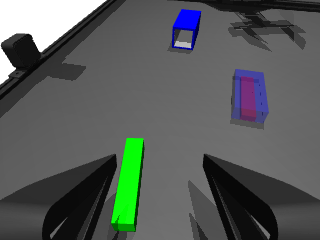

In [8]:
i = 4
def unvmap(x):
    return jax.tree_map(lambda y: y[i], x)

media.show_image(env.render(unvmap(state), 
                            camera='wrist_cam_right',
                            scene_option=scene_option))